In [2]:
library(ggplot2)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#-------------------------------------------------------------
#* 根据遗传力的大小，统计这些eGene在cis和trans遗传力上的分布
#-------------------------------------------------------------
eGene_Genetic=read.table("./Allstage_eGene_Genetic.txt",header=T)
head(eGene_Genetic)

,eGene,Lead_genetic,noLead_genetic,trans_genetic,stage,cis_genetic,trans_genetic_V2
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,Ghir_A05G023040,0.139872_0.167558,0.093819_0.057508,0.020000_0.039962,0DPA,0.233691,0.020000
2,Ghir_A05G004080,0.639230_0.115566,0.000001_0.002888,0.003882_0.014876,0DPA,0.639231,0.003882
3,Ghir_D05G004210,None,0.347287_0.083344,0.028087_0.038062,0DPA,0.347287,0.028087
4,Ghir_A10G022660,0.523993_0.114105,0.000002_0.009771,0.094775_0.045700,0DPA,0.523995,0.094775
5,Ghir_A12G025160,None,0.258503_0.066755,0.024011_0.037563,0DPA,0.258503,0.024011
6,Ghir_D12G025160,0.332758_0.124006,0.004025_0.009877,0.000521_0.027198,0DPA,0.336783,0.000521


Warning message:
“Removed 595 rows containing missing values (geom_point).”


png 
  2

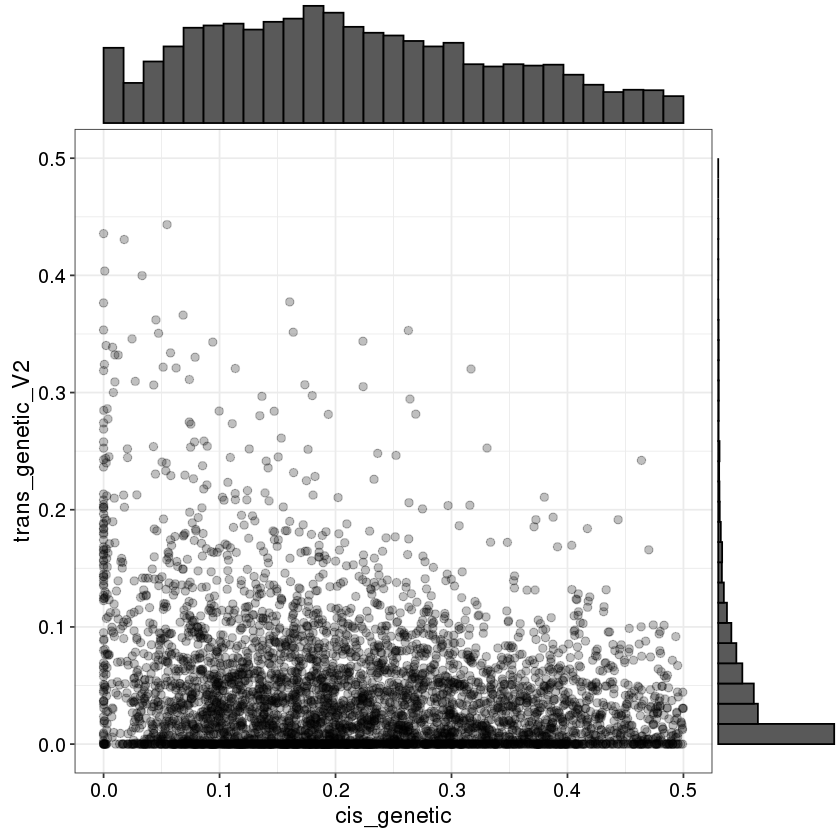

In [38]:
library(LSD)
library(ggExtra)
gg <- ggplot(
    eGene_Genetic, aes(x = cis_genetic, y = trans_genetic_V2)
    ) + 
    geom_point(alpha = .25, size = 2) +
    scale_x_continuous(limits = c(0, 0.5)) +
    scale_y_continuous(limits = c(0, 0.5))

gg <- gg + theme_bw() +
    theme(
        axis.title = element_text(size = 14, color = "black"),
        axis.text = element_text(size = 12, color = "black"),
    )
p1 <- ggMarginal(gg,
    type = "histogram",
    )
svg("Genetic_Parition.svg")
print(p1)
dev.off()
p1

png 
  2

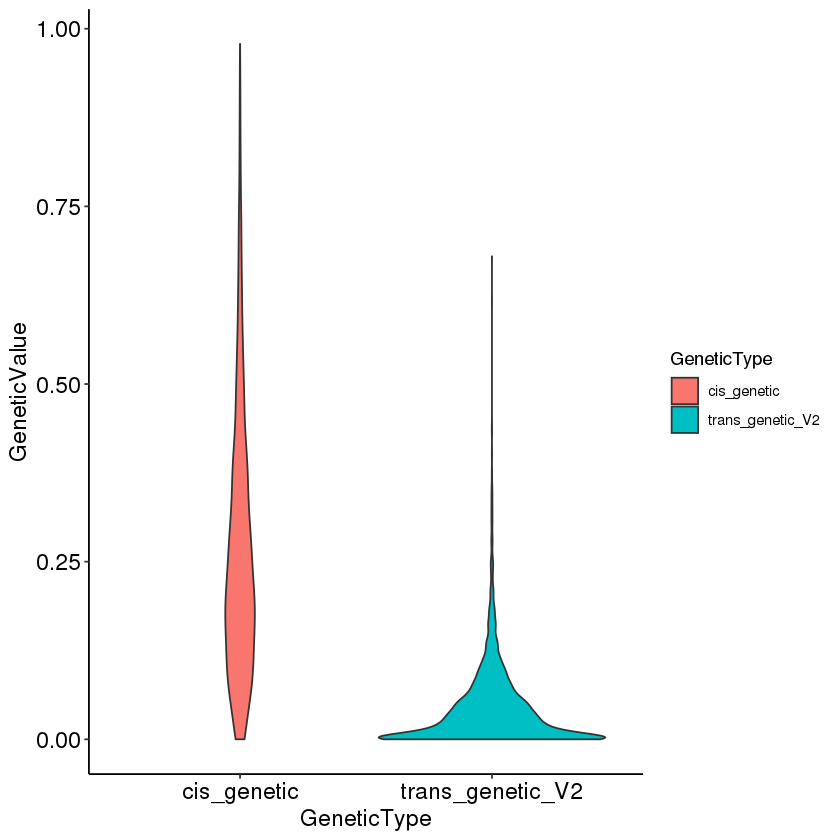

In [39]:
library(tidyr)
p=eGene_Genetic %>%
    pivot_longer(
        cols = c(cis_genetic, trans_genetic_V2),
        names_to = c("GeneticType"),
        values_to = c("GeneticValue")
    ) %>%
    ggplot(aes(x = GeneticType, y = GeneticValue, fill = GeneticType)) +
    geom_violin() +
    theme_classic() +
    theme(
        axis.title = element_text(size = 14, color = "black"),
        axis.text = element_text(size = 14, color = "black")
    )
svg("cis_trans_genetic.svg")    
print(p)
dev.off()
p

In [73]:
#-------------------------------------------------------------
#* 在鉴定到cis-eQTL的这些eGene中
#* lead SNP cluster所解释的遗传力显著的高于cis区域的其他SNP，
# ? 这也与之前的结果一致，大多数eGene在cis区域只受到一个eQTL的调控
#------------------------------------------------------------
filterGenetic <- eGene_Genetic %>% filter(Lead_genetic != "None")
filterGenetic$Lead_genetic=as.double(as.character(filterGenetic$Lead_genetic))
#* no-lead SNP区域遗传力小于0.01则认为没有显著的QTL
sig_noLeadSNP=filterGenetic %>% filter(noLead_genetic>=0.05)


In [3]:
MergeData=data.frame(
    genePair=c(),
    eGene=c(),
    leadSNP=c(),
    leadGenetic=c(),
    leadGenetic_se=c(),
    Converged=c(),
    ldFriend=c(),
    conservedCount=c(),
    specialCount=c(),
    stage=c()
)
for(stage in c("0DPA","4DPA","8DPA","12DPA","16DPA","20DPA")){
    tmpData=read.table(paste(stage,"_leadSNP_conserved2_multipleTest.txt",sep=""),header = T)
    tmpData$stage=stage
    MergeData=rbind(MergeData,tmpData)
}

filterData=MergeData %>% filter(leadGenetic!="None")
filterData$leadGenetic=as.double(as.character(filterData$leadGenetic))
filterData$leadGenetic_se=as.double(as.character(filterData$leadGenetic_se))
filterData=filterData %>% mutate(
    conservedRatio = conservedCount / (conservedCount + specialCount),
    geneticRank=round(leadGenetic*10)
    )
filterData1=filterData %>% filter(geneticRank<5)
filterData2=filterData %>% filter(geneticRank>=5)
filterData2$geneticRank=5
filterData=rbind(filterData1,filterData2)
# #* 
filterData$geneticRank=as.factor(filterData$geneticRank)
#filterData=filterData %>% filter(geneticRank!=0)
filterData %>% 
     filter(Converged!="NO") %>%
     count(geneticRank) 
filterData %>% head()

geneticRank,n
<fct>,<int>
0,281
1,1065
2,1195
3,1061
4,783
5,664


,genePair,eGene,leadSNP,leadGenetic,leadGenetic_se,Converged,ldFriend,conservedCount,specialCount,stage,conservedRatio,geneticRank
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<chr>,<dbl>,<fct>
1,Ghir_A05G023040-Ghir_D05G022930,Ghir_A05G023040,SNP311357,0.141817,0.091263,YES,476,218,257,0DPA,0.4589474,1
2,Ghir_A12G025160-Ghir_D12G025160,Ghir_D12G025160,SNP2599302,0.412618,0.117903,YES,424,225,198,0DPA,0.5319149,4
3,Ghir_A05G005510-Ghir_D05G005590,Ghir_A05G005510,SNP294167,0.319173,0.098883,YES,299,197,101,0DPA,0.6610738,3
4,Ghir_A03G022620-Ghir_D02G024060,Ghir_D02G024060,SNP1819443,0.142228,0.074022,YES,531,322,208,0DPA,0.6075472,1
5,Ghir_A03G021620-Ghir_D02G023110,Ghir_D02G023110,SNP1818572,0.178984,0.106602,YES,222,171,50,0DPA,0.7737557,2
6,Ghir_A08G023930-Ghir_D08G024840,Ghir_A08G023930,SNP1041068,0.077489,0.049591,YES,349,242,106,0DPA,0.6954023,1


In [4]:
filterData %>%
    group_by(geneticRank) %>%
    summarise(mean(leadGenetic))

geneticRank,mean(leadGenetic)
<fct>,<dbl>
0,0.02508852
1,0.10426155
2,0.19890617
3,0.29916206
4,0.39609386
5,0.55042221


In [5]:
#----------------------------
#* 获取随机状态
#----------------------------
randomSNP <- read.table("random_SNPs/random_SNP_conservedRatio.txt", header = T, sep = "\t")
randomSNP <- randomSNP %>% mutate(conservedRatio = conservedSNPCount / totalSNPCount, geneticRank = '-1')
MergeData <- rbind(
    filterData   %>% filter(Converged!="NO") %>% select(geneticRank, conservedRatio),
    # filterData %>% filter(leadGenetic_se <= 0.1) %>% select(geneticRank, conservedRatio),
    randomSNP %>% select(geneticRank, conservedRatio)
)

In [6]:
#* SNP遗传力与其在两个亚组间保守情况
filterData2 <- filterData %>% filter(Converged != "NO")
cor.test(
    filterData2$conservedRatio,
    filterData2$leadGenetic
)


	Pearson's product-moment correlation

data:  filterData2$conservedRatio and filterData2$leadGenetic
t = 7.3392, df = 5047, p-value = 2.492e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.07538945 0.12997622
sample estimates:
      cor 
0.1027602 


In [21]:
filterData %>%
    filter(leadGenetic > 0.4) %>%
    select(ldFriend) %>%
    lapply(median)

$ldFriend
[1] 378

In [22]:
filterData %>%
    filter(leadGenetic > 0.2 & leadGenetic < 0.3 ) %>%
    select(ldFriend) %>%
    lapply(median)

$ldFriend
[1] 401.5

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



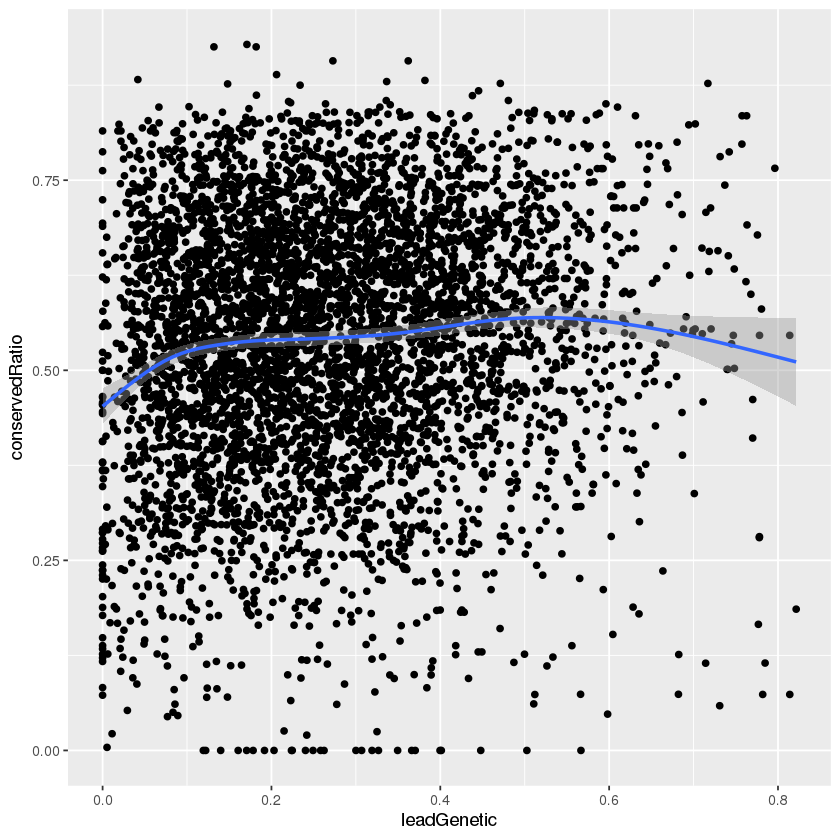

In [27]:
#----------------------------------------------------------------------------------------
# ! 随着遗传力的增加，ld block内的SNP在亚组间保守占比是在不断增加的；
#* 而在很高遗传力的这些ld Block，保守的比例不是最高的？
# ? 这类遗传力特别高的位点难道是更亚组间特异一些？
#* 遗传力的高低是与ld block内SNP的数目相关的，因此在比较时可以看看这些Block内SNP数目有无显著差异
#----------------------------------------------------------------------------------------
filterData %>%
    filter(Converged != "NO") %>%
    ggplot(aes(x = leadGenetic, y = conservedRatio)) +
    geom_point() +
    geom_smooth(
        method = "gam"
    )

In [29]:
mean(a[,2])
mean(b[,2])

[1] 0.5261705

[1] 0.5481121

In [9]:
MergeData %>% count(geneticRank)

geneticRank,n
<fct>,<int>
0,281
1,1065
2,1195
3,1061
4,783
5,664
-1,867


In [12]:
a <- MergeData %>% filter(geneticRank == 0)
b <- MergeData %>% filter(geneticRank %in% c(1))
wilcox.test(
    a[, 2],
    b[, 2],
    alternative ="two.sided"
)


	Wilcoxon rank sum test with continuity correction

data:  a[, 2] and b[, 2]
W = 127436, p-value = 0.0001284
alternative hypothesis: true location shift is not equal to 0


png 
  2

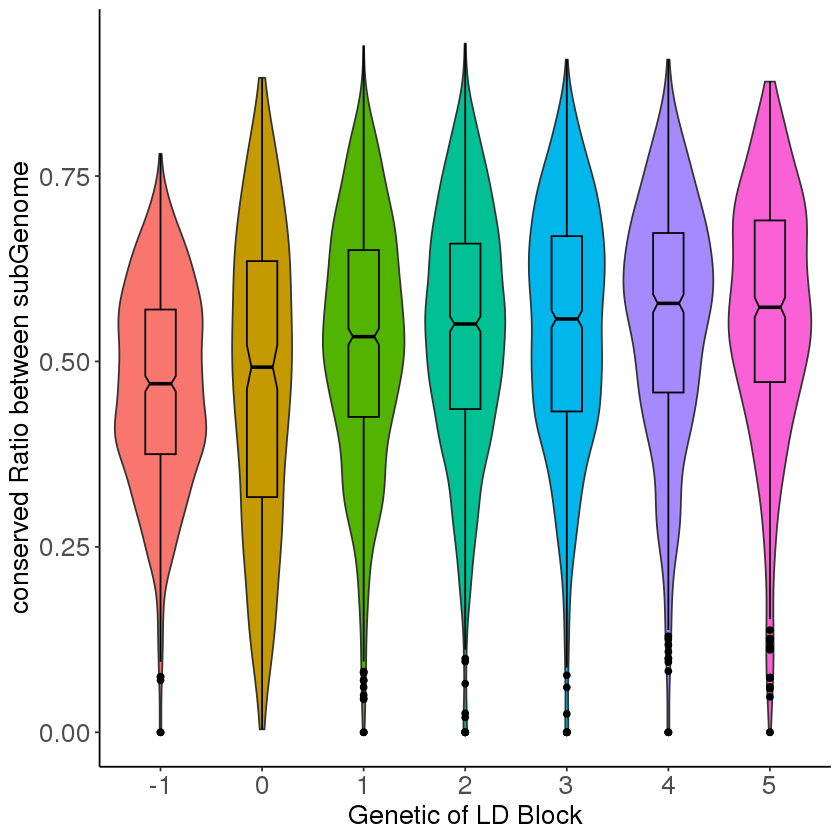

In [25]:
library(RColorBrewer)
MergeData$geneticRank=factor(MergeData$geneticRank,levels = c(-1,0,1,2,3,4,5,6,7,8))
p=MergeData %>%
    ggplot(aes(x = geneticRank, y = conservedRatio,fill=geneticRank)) +
    geom_violin()+
    geom_boxplot(
        notch = T,
        notchwidth = 0.7,
        color='black',
        width=0.3
    )+
    theme_classic()+
    theme(
        legend.position = "none",
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 16)
    )+
    # scale_fill_manual(
    #     values = brewer.pal(6,"OrRd")
    # )+
    # scale_y_continuous(
    #     limits = c(0,1)
    # )+
    xlab("Genetic of LD Block")+
    ylab("conserved Ratio between subGenome")

pdf("ConservedRatio_across_GeneticRank_multipleTest.pdf")
print(p)
dev.off()
p

Warning message:
“Removed 4 rows containing non-finite values (stat_density).”


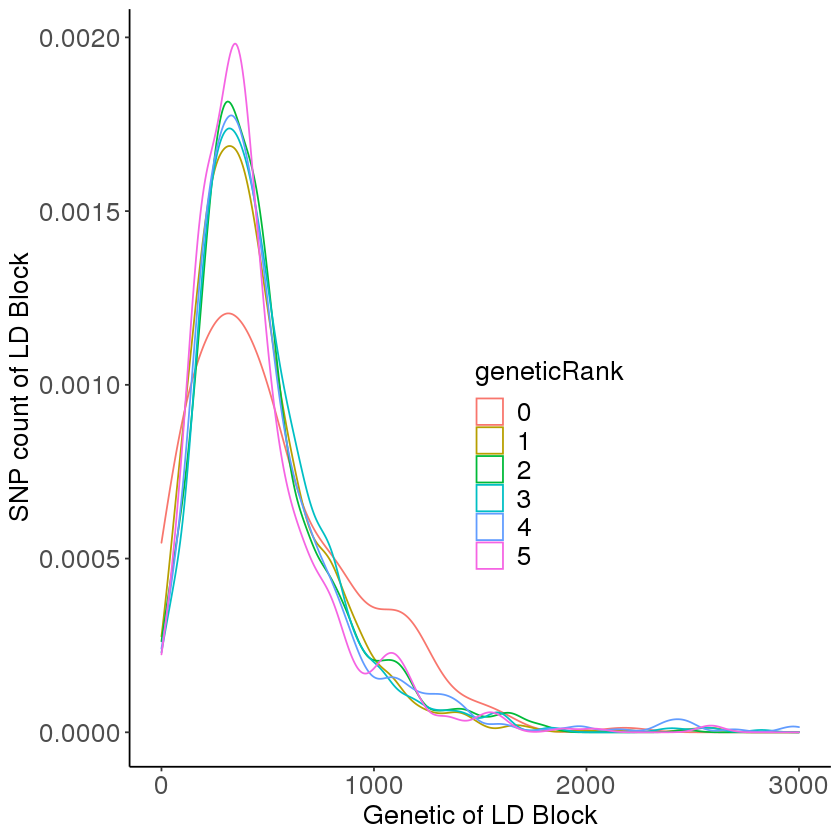

In [42]:
filterData %>%
    filter(Converged == "YES") %>%
    ggplot(aes(
        x = ldFriend, color = geneticRank
    )) +
    geom_density() +
    theme_classic() +
    theme(
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 16),
        legend.position = c(0.6, 0.4),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 16)
    ) +
    # scale_color_manual(
    #     values = brewer.pal(5, "OrRd")
    # ) +
    scale_x_continuous(
        limits = c(0, 3000)
    ) +
    xlab("Genetic of LD Block") +
    ylab("SNP count of LD Block")

In [29]:
test1 <- MergeData %>% filter(geneticRank == 4)
test2 <- MergeData %>% filter(geneticRank == 1)
wilcox.test(
    test1$conservedRatio,
    test2$conservedRatio,
    paired = F
)


	Wilcoxon rank sum test with continuity correction

data:  test1$conservedRatio and test2$conservedRatio
W = 469910, p-value = 5.085e-05
alternative hypothesis: true location shift is not equal to 0


In [48]:
#* 对每个Block区域内的SNP数目进行比较
test1 <- filterData %>%
    filter(Converged == "YES") %>%
    filter(geneticRank == 4)
test2 <- filterData %>%
    filter(Converged == "YES") %>%
    filter(geneticRank == 5)
wilcox.test(
    test1$ldFriend,
    test2$ldFriend,
    paired = F
)


	Wilcoxon rank sum test with continuity correction

data:  test1$ldFriend and test2$ldFriend
W = 284248, p-value = 0.05758
alternative hypothesis: true location shift is not equal to 0


In [56]:
#------------------------------------------------------
#* 按照cis遗传力的大小，分析调控片段在两个亚组间的保守比例
#------------------------------------------------------
MergeData <- data.frame(
    genePair = c(),
    eGene = c(),
    leadSNP = c(),
    cis = c(),
    trans = c(),
    conservedRegion = c(),
    conservedType = c()
)
for (stage in c("0DPA","4DPA","8DPA","12DPA","16DPA","20DPA")){
    tmpData=read.table(paste(stage,"_leadSNP_conserved.txt",sep=""),header=T)
    MergeData=rbind(MergeData,tmpData)
}

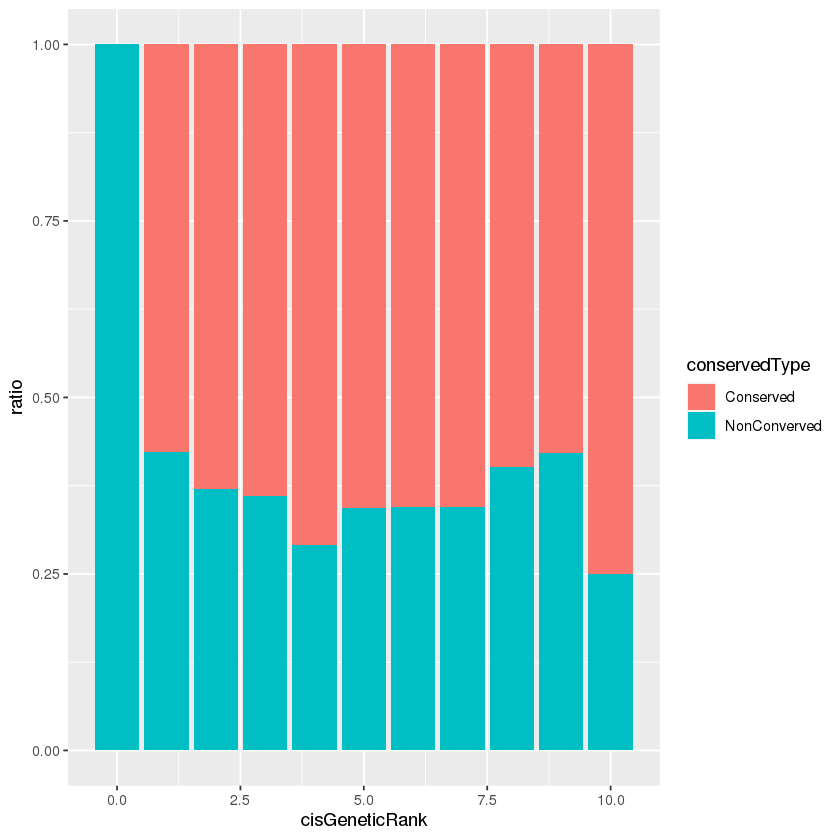

In [59]:
MergeData %>%
    mutate(cisGeneticRank = ceiling(cis * 10)) %>%
    count(cisGeneticRank, conservedType) %>%
    group_by(cisGeneticRank) %>%
    mutate(total = sum(n), ratio = n / total) %>%
    ggplot(
        aes(x=cisGeneticRank,y=ratio,fill=conservedType)
    )+geom_bar(stat="identity")